In [1]:
import pandas as pd
from opensky_api import OpenSkyApi
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
import geopandas


# Airlines

In [2]:
df_airlines = pd.read_csv("data/airlines.dat", names=['id','name','alias','iata','icao','callsign','country','active'])
df_airlines.head()

,id,name,alias,iata,icao,callsign,country,active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
2,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N


# Airport data

In [3]:
# https://openflights.org/data.html#airport
df_airports = pd.read_csv("data/airports.dat", header= None, dtype=str)
df_airports.columns = ["id", "name", "city", "country", "iata", "icao", "latitude", "longitude", "altitude", "timezone", "dst", "databasetimezone","type ","source "]
df_airports.head()

,id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,databasetimezone,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689834590001,145.391998291,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20707988739,145.789001465,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789855957031,144.29600524902344,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380355834961,147.22000122070312,146,10,U,Pacific/Port_Moresby,airport,OurAirports


# Routes

In [4]:
# https://openflights.org/data.html#route
df_routes = pd.read_csv("data/routes.dat", header= None, dtype=str)
df_routes.columns = ['airline','airline_id','source','source_id','dest','dest_id','codeshare','stops','equipments']
df_routes = df_routes[df_routes["airline_id"] != "\\N"]
print(len(df_routes))
df_routes = df_routes.fillna(0)
df_routes.head()


67184


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipments
0,2B,410,AER,2965,KZN,2990,0,0,CR2
1,2B,410,ASF,2966,KZN,2990,0,0,CR2
2,2B,410,ASF,2966,MRV,2962,0,0,CR2
3,2B,410,CEK,2968,KZN,2990,0,0,CR2
4,2B,410,CEK,2968,OVB,4078,0,0,CR2


# Calcul nb_flights par routes

In [5]:
res = df_routes.groupby(['source']).size().sort_values(ascending=False)
dest = df_routes.groupby(['dest']).size().sort_values(ascending=False)
both = pd.concat([res, dest], axis=1, keys=['source_routes','dest_routes'] ,sort=False)
both = both.fillna(0)
both['source'] = both.index

both['source_routes'] = both.source_routes.astype(int)
both['dest_routes'] = both.dest_routes.astype(int)
both['nb_flights'] = both['dest_routes']+both['source_routes']
both = both.drop(["dest_routes", "source_routes"], axis=1)
print(both.head())


    source  nb_flights
ATL    ATL        1826
ORD    ORD        1108
PEK    PEK        1069
LHR    LHR        1051
CDG    CDG        1041


In [6]:
df_routes_merge = pd.merge(df_routes, both, on='source')
df_routes_merge.head()


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipments,nb_flights
0,2B,410,AER,2965,KZN,2990,0,0,CR2,52
1,7J,9531,AER,2965,DYU,2979,0,0,735,52
2,9U,1073,AER,2965,KIV,1735,0,0,EM2,52
3,B2,1478,AER,2965,MSQ,2954,0,0,735 CRJ,52
4,HY,5281,AER,2965,TAS,2983,0,0,767,52


In [7]:
air = df_routes.groupby(['airline'])
print(len(air))
air.head()


547


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipments
0,2B,410,AER,2965,KZN,2990,0,0,CR2
1,2B,410,ASF,2966,KZN,2990,0,0,CR2
2,2B,410,ASF,2966,MRV,2962,0,0,CR2
3,2B,410,CEK,2968,KZN,2990,0,0,CR2
4,2B,410,CEK,2968,OVB,4078,0,0,CR2
42,2G,1654,BTK,2936,IKT,2937,0,0,A81
43,2G,1654,BTK,2936,OVB,4078,0,0,A81
44,2G,1654,CEK,2968,OVB,4078,0,0,A81
45,2G,1654,HTA,2935,IKT,2937,0,0,AN4
46,2G,1654,IKT,2937,BTK,2936,0,0,A81


# Formule de Haversine
La formule de Haversine permet de déterminer la distance du grand cercle entre deux points d'une sphère, à partir de leurs longitudes et latitudes. 

In [8]:
import math
def haversine(lon1, lat1, lon2, lat2):
    # Convert coordinates to floats.
    lon1, lat1, lon2, lat2 = [float(lon1), float(lat1), float(lon2), float(lat2)]
    # Convert to radians from degrees.
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # Compute distance.
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    km = 6367 * c
    return km

# Calculs 

Calcul de la distance entre 2 aéroports pour une seule route

In [9]:
def calc_dist(row):
    dist = 0
    try:
        # Match source and destination to get coordinates.
        source = df_airports[df_airports["id"] == row["source_id"]].iloc[0]
        dest = df_airports[df_airports["id"] == row["dest_id"]].iloc[0]
        # Use coordinates to compute distance.
        dist = haversine(dest["longitude"], dest["latitude"], source["longitude"], source["latitude"])
    except (ValueError, IndexError):
        pass
    return dist

In [10]:
route_lengths = df_routes.apply(calc_dist, axis=1)

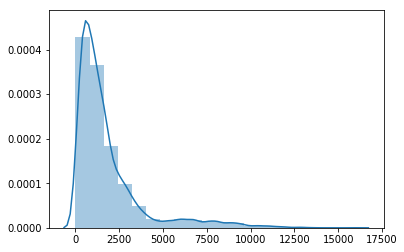

In [11]:
import seaborn 
seaborn.distplot(route_lengths, bins=20)

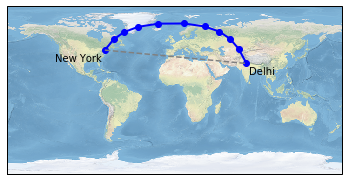

In [12]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='gray', linestyle='--',
         transform=ccrs.PlateCarree(),
         )

plt.text(ny_lon - 3, ny_lat - 12, 'New York',
         horizontalalignment='right',
         transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, 'Delhi',
         horizontalalignment='left',
         transform=ccrs.Geodetic())

plt.show()

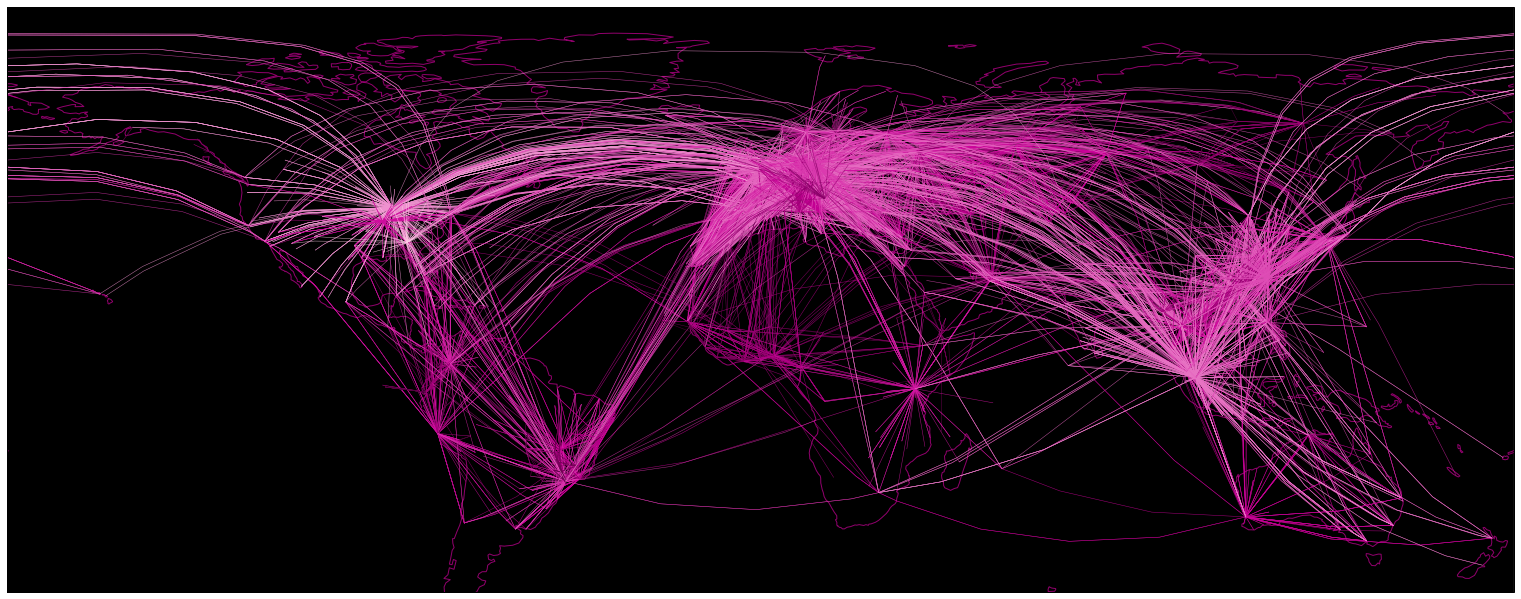

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,to_rgba
from matplotlib import cm

bg_color = (0.0, 0.0, 0, 1.0)
coast_color = (204/255.0, 0, 153/255.0, 0.7)
color_list = [(0.0, 0.0, 0.0, 0.0),(204/255.0, 0, 153/255.0, 0.6),(255/255.0, 204/255.0, 230/255.0, 1.0)]

n = len(df_routes_merge)

# normalize the dataset for color scale
#norm = PowerNorm(0.3, traffic_final['sumtraffic'].min(),traffic_final['sumtraffic'].max())
norm = PowerNorm(0.3, df_routes_merge['nb_flights'].min(), df_routes_merge['nb_flights'].max())

#cmap = cm.get_cmap('viridis')
cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list, N=n)

fig = plt.figure(figsize=(27,27))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines(color=coast_color, linewidth=1.0)
ax.add_feature(cfeature.LAND,color="black")
ax.add_feature(cfeature.OCEAN,color="black")

    
#ax.stock_img()
for name, row in df_routes_merge[:10000].iterrows():
        try :
            color = cmap(norm(int(row['nb_flights'])))
            colors=to_rgba(color)
            source = df_airports[df_airports["id"] == row["source_id"]].iloc[0]
            dest = df_airports[df_airports["id"] == row["dest_id"]].iloc[0]
            #print(source['longitude'], dest['latitude'])
            ax.plot([float(source['longitude']), float(dest['longitude'])], [float(source['latitude']), 
                                                                                  float(dest['latitude'])],
                 alpha=0.8, linewidth=0.5,color=colors,
                 transform=ccrs.Geodetic(),
                 )
        except (ValueError, IndexError):
            pass
        


# Seconde partie routes depuis CDG Airport

In [14]:
df_cdg = df_routes.loc[df_routes['source'] == 'CDG']
#df_cdg = df_routes
df_cdg.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipments
1265,4U,2548,CDG,1382,HAM,342,0,0,319 CRJ
3245,8Q,3788,CDG,1382,IST,1701,0,0,320
4317,A3,96,CDG,1382,ATH,3941,0,0,321 320
4318,A3,96,CDG,1382,HER,1452,0,0,320
4319,A3,96,CDG,1382,RHO,1472,0,0,320


In [15]:
len(df_cdg)

524

# 3e partie routes avec folium

In [16]:
#df_cdg = df_routes.loc[(df_routes['source'] == 'CDG') & (df_routes['airline']=='AF')]
df_cdg = df_routes.loc[df_routes['airline']=='AF']

#df_cdg = df_routes
print(len(df_cdg))
df_cdg.head()

1071


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipments
8968,AF,137,ABE,4355,ATL,3682,Y,0,CRJ
8969,AF,137,ABJ,253,CDG,1382,0,0,772
8970,AF,137,ABQ,4019,ATL,3682,Y,0,757 320
8971,AF,137,ABV,260,CDG,1382,0,0,332
8972,AF,137,ABV,260,PHC,275,0,0,332


In [17]:
df_cdg = df_cdg.drop(["codeshare", "stops", "equipments"], axis=1)
df_cdg = df_cdg.assign(source_lat=df_cdg.source_id)
df_cdg = df_cdg.assign(source_long=df_cdg.source_id)
df_cdg = df_cdg.assign(dest_lat=df_cdg.dest_id)
df_cdg = df_cdg.assign(dest_long=df_cdg.dest_id)
df_cdg = df_cdg.assign(airline_name=df_cdg.airline)
df_cdg = df_cdg.assign(color_airline = None)

df_cdg.head()

,airline,airline_id,source,source_id,dest,dest_id,source_lat,source_long,dest_lat,dest_long,airline_name,color_airline
8968,AF,137,ABE,4355,ATL,3682,4355,4355,3682,3682,AF,None
8969,AF,137,ABJ,253,CDG,1382,253,253,1382,1382,AF,None
8970,AF,137,ABQ,4019,ATL,3682,4019,4019,3682,3682,AF,None
8971,AF,137,ABV,260,CDG,1382,260,260,1382,1382,AF,None
8972,AF,137,ABV,260,PHC,275,260,260,275,275,AF,None


In [18]:
lat = df_airports.set_index('id')['latitude']
df_cdg["source_lat"] = df_cdg["source_lat"].replace(lat) 
long = df_airports.set_index('id')['longitude']
df_cdg["source_long"] = df_cdg["source_long"].replace(long) 

latd = df_airports.set_index('id')['latitude']
df_cdg["dest_lat"] = df_cdg["dest_lat"].replace(latd) 

longd = df_airports.set_index('id')['longitude']
df_cdg["dest_long"] = df_cdg["dest_long"].replace(longd)

airl = df_airlines.set_index('iata')['name']
df_cdg['airline_name'] = df_cdg['airline_name'].replace(airl)

df_cdg.head()

,airline,airline_id,source,source_id,dest,dest_id,source_lat,source_long,dest_lat,dest_long,airline_name,color_airline
8968,AF,137,ABE,4355,ATL,3682,40.652099609375,-75.44080352783203,33.6367,-84.428101,Air France,None
8969,AF,137,ABJ,253,CDG,1382,5.261390209197998,-3.9262900352478027,49.012798,2.55,Air France,None
8970,AF,137,ABQ,4019,ATL,3682,35.040199,-106.609001,33.6367,-84.428101,Air France,None
8971,AF,137,ABV,260,CDG,1382,9.006790161132812,7.263169765472412,49.012798,2.55,Air France,None
8972,AF,137,ABV,260,PHC,275,9.006790161132812,7.263169765472412,5.0154900550842285,6.94959020614624,Air France,None


In [19]:
colour = [ "red", "blue", "green", "yellow", "purple", "orange", "white", "black" ]

In [20]:
import folium
import sys


m = folium.Map(location=[48.86, 2.33])

for index,row  in df_cdg.head(300).iterrows():
        try:
            dest = df_airports[df_airports["id"] == row["dest_id"]].iloc[0]
            source = df_airports[df_airports["id"] == row["source_id"]].iloc[0]

            color_random = random.choice(colour)
            folium.PolyLine(locations = [(float(row.source_lat), float(row.source_long)),(float(row.dest_lat), 
                        float(row.dest_long))],weight=1, color=color_random).add_to(m) 
            folium.Marker((float(row.dest_lat), float(row.dest_long)), popup=dest['name']).add_to(m)
            folium.Marker((float(row.source_lat), float(row.source_long)), popup=source['name']).add_to(m)

        except:
            pass



In [21]:
m

## Couleur par airlines

In [22]:
compagnies = df_cdg['airline_name'].unique()
print(compagnies[0:5])
print(len(compagnies))

['Air France']
1


In [23]:
import random
list_number = []
x = 0
while x < len(compagnies):
    #list_number.append(random.randint(0,7))
    colornum = "#%06x" % random.randint(0, 0xFFFFFF)
    list_number.append(colornum)
    x=x+1
#print(list_number)

# Create a zip object from two lists
zipbObj = zip(compagnies, list_number)
 
# Create a dictionary from zip object
dictOfWords = dict(zipbObj)

n=0
for key,val in dictOfWords.items():
               dictOfWords[key] = list_number[n]
               n=n+1

#print(dictOfWords)  

In [24]:
#gapminder_df['pop']= gapminder_df['continent'].map(pop_dict)
df_cdg['couleurnew']= df_cdg['airline_name'].map(dictOfWords)
df_cdg.head()

,airline,airline_id,source,source_id,dest,dest_id,source_lat,source_long,dest_lat,dest_long,airline_name,color_airline,couleurnew
8968,AF,137,ABE,4355,ATL,3682,40.652099609375,-75.44080352783203,33.6367,-84.428101,Air France,None,#00e801
8969,AF,137,ABJ,253,CDG,1382,5.261390209197998,-3.9262900352478027,49.012798,2.55,Air France,None,#00e801
8970,AF,137,ABQ,4019,ATL,3682,35.040199,-106.609001,33.6367,-84.428101,Air France,None,#00e801
8971,AF,137,ABV,260,CDG,1382,9.006790161132812,7.263169765472412,49.012798,2.55,Air France,None,#00e801
8972,AF,137,ABV,260,PHC,275,9.006790161132812,7.263169765472412,5.0154900550842285,6.94959020614624,Air France,None,#00e801


In [25]:
import folium
import sys
import random

m = folium.Map(location=[48.86, 2.33])

for index,row  in df_cdg.head(300).iterrows():
        try:
            dest = df_airports[df_airports["id"] == row["dest_id"]].iloc[0]
            source = df_airports[df_airports["id"] == row["source_id"]].iloc[0]

            color_random = random.choice(colour)
            folium.PolyLine(locations = [(float(row.source_lat), float(row.source_long)),(float(row.dest_lat), 
                        float(row.dest_long))],weight=2, color=row.couleurnew).add_to(m) 
            folium.Marker((float(row.dest_lat), float(row.dest_long)), popup=dest['name']).add_to(m)
            folium.Marker((float(row.source_lat), float(row.source_long)), popup=source['name']).add_to(m)

        except:
            pass

In [26]:
m

In [27]:
df_routes_airlines_cdg = df_cdg.groupby(['airline']).size().sort_values(ascending=False)
df_routes_airlines_cdg.head(10)


airline
AF    1071
dtype: int64